[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Testing (0, 0, 0) x (0, 0, 0, 12) - R2: 0.7674329427827851
Testing (0, 0, 0) x (0, 0, 1, 12) - R2: 0.7822710330050484
Testing (0, 0, 0) x (0, 1, 0, 12) - R2: 0.4211487886877622
Testing (0, 0, 0) x (0, 1, 1, 12) - R2: 0.6286705858066344
Testing (0, 0, 0) x (1, 0, 0, 12) - R2: 0.7715836064162495
Testing (0, 0, 0) x (1, 0, 1, 12) - R2: 0.7843117951255063
Testing (0, 0, 0) x (1, 1, 0, 12) - R2: 0.5261313767831776
Testing (0, 0, 0) x (1, 1, 1, 12) - R2: 0.5908536913337838
Testing (0, 0, 1) x (0, 0, 0, 12) - R2: 0.762959163006837
Testing (0, 0, 1) x (0, 0, 1, 12) - R2: 0.7779095561067149
Testing (0, 0, 1) x (0, 1, 0, 12) - R2: 0.425593313277302
Testing (0, 0, 1) x (0, 1, 1, 12) - R2: 0.616927837659262
Testing (0, 0, 1) x (1, 0, 0, 12) - R2: 0.7654021129448062
Testing (0, 0, 1) x (1, 0, 1, 12) - R2: 0.7760130879074498
Testing (0, 0, 1) x (1, 1, 0, 12) - R2: 0.5382770979975688
Testing (0, 0, 1) x (1, 1, 1, 12) - R2: 0.5990496810719876
Testing (0, 1, 0) x (0, 0, 0, 12) - R2: 0.21605849348296688

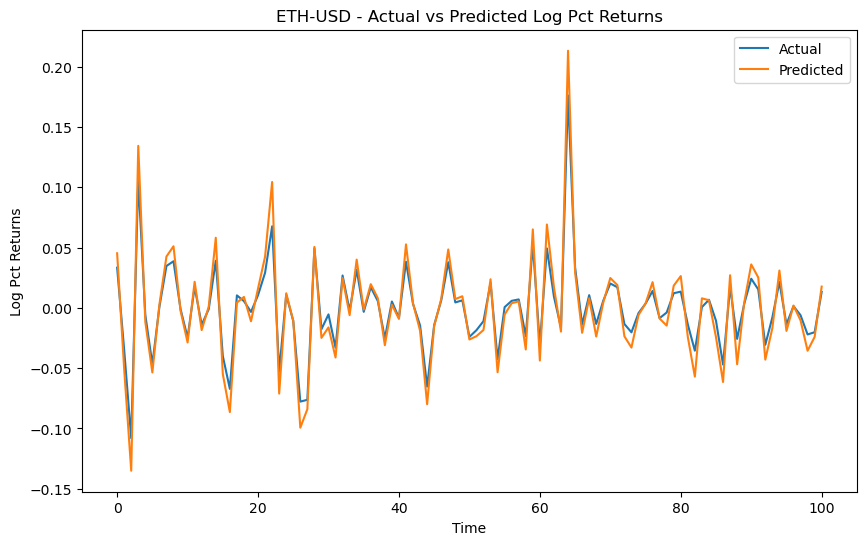

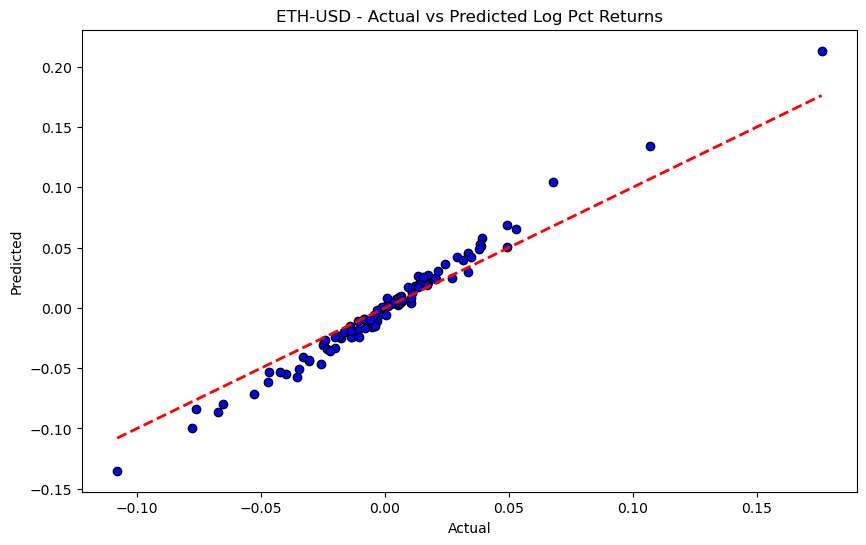

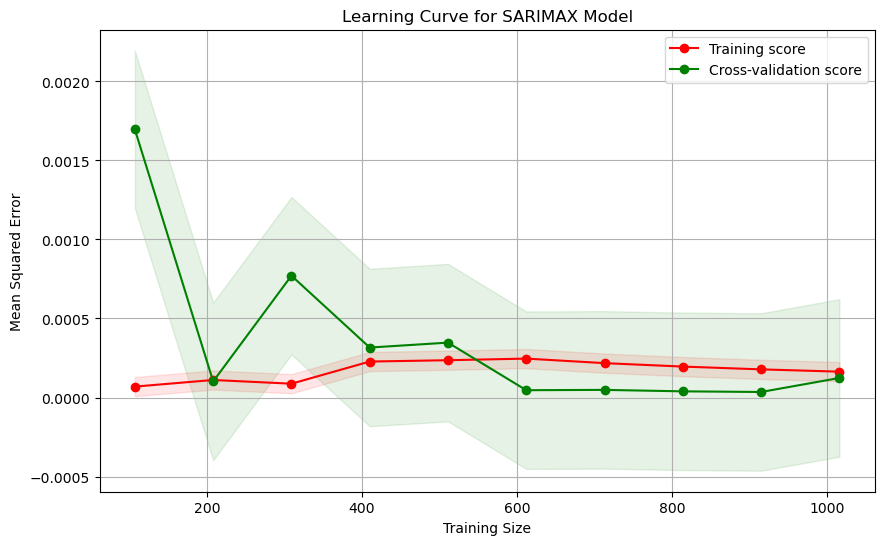

Future predictions saved to eth_usd_future_predictions.csv


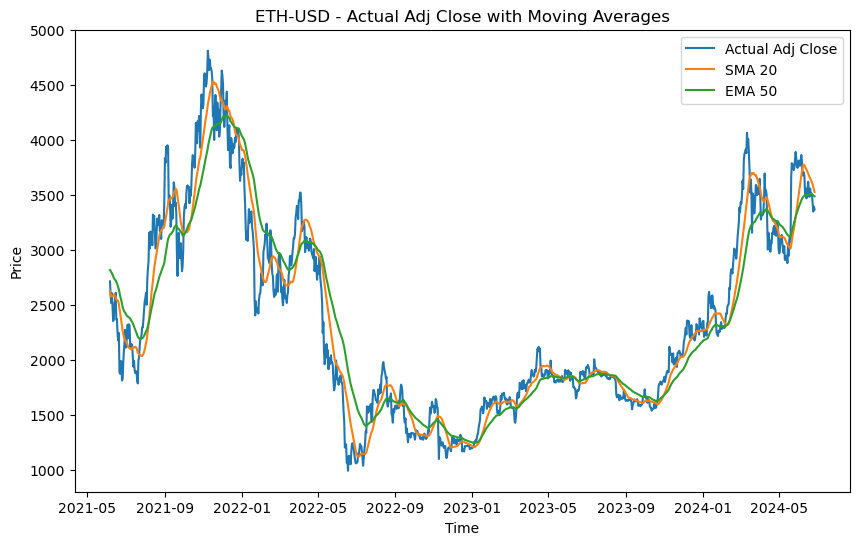

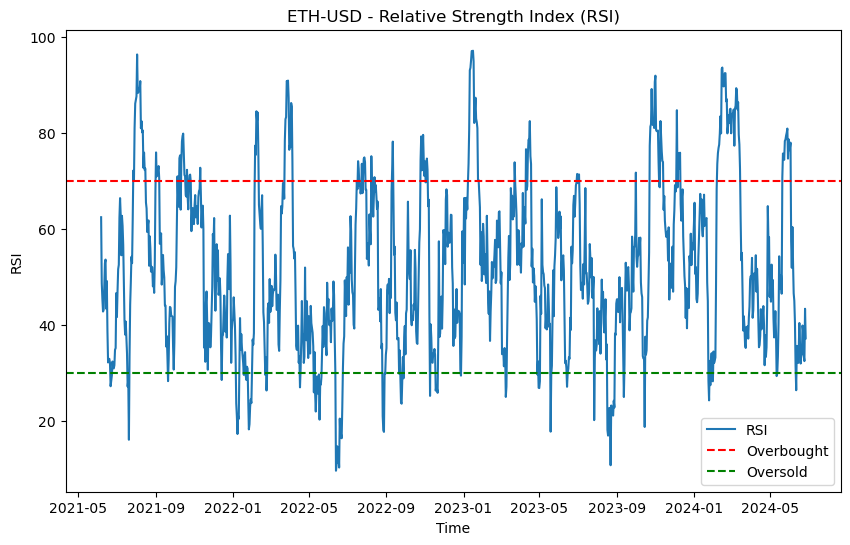

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

def download_data(ticker, start_date, end_date):
    data = yf.download(tickers=ticker, start=start_date, end=end_date)
    df = pd.DataFrame(data)
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    return df

def add_features(df, df_gold, df_usindex):
    df['Gold_Adj_Close'] = df_gold['Adj Close']
    df['USIndex_Adj_Close'] = df_usindex['Adj Close']
    df.ffill(inplace=True)

    # Calculate additional features
    df['Open_Close_Diff'] = df['Open'] - df['Adj Close']
    df['High_Low_Diff'] = df['High'] - df['Low']
    df['Pct_Returns'] = df['Adj Close'].pct_change()
    df['Log_Pct_Returns'] = np.log(1 + df['Pct_Returns'])
    df.dropna(inplace=True)

    # Moving Averages
    df['SMA_5'] = df['Adj Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
    df['EMA_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()

    # Relative Strength Index (RSI)
    window_length = 14
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
    loss = (-delta.where(delta<0, 0)).rolling(window=window_length).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    df['MACD'] = df['Adj Close'].ewm(span=12, adjust=False).mean() - df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

    # Bollinger Bands
    df['BB_Upper'] = df['SMA_20'] + 2 * df['Adj Close'].rolling(window=20).std()
    df['BB_Lower'] = df['SMA_20'] - 2 * df['Adj Close'].rolling(window=20).std()

    # Stochastic Oscillator
    df['14-high'] = df['High'].rolling(14).max()
    df['14-low'] = df['Low'].rolling(14).min()
    df['%K'] = (df['Adj Close'] - df['14-low']) * 100 / (df['14-high'] - df['14-low'])
    df['%D'] = df['%K'].rolling(3).mean()

    # Average True Range (ATR)
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = np.abs(df['High'] - df['Adj Close'].shift(1))
    df['L-PC'] = np.abs(df['Low'] - df['Adj Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(14).mean()

    return df

def shift_columns(df, columns_to_shift, num_lags):
    for column in columns_to_shift:
        for lag in range(1, num_lags + 1):
            df[f'{column}_{lag}'] = df[column].shift(lag)
    df['Pct_Returns_1'] = df['Pct_Returns'].shift(1)
    df['Log_Pct_Returns_1'] = df['Log_Pct_Returns'].shift(1)
    df.dropna(inplace=True)
    return df

def fetch_and_preprocess_economic_data(start_date, end_date):
    economic_indicators = {
        'T5YIE': 'Inflation',
        'FEDFUNDS': 'FedFunds',
        'GDPC1': 'GDP',
        'UNRATE': 'Unemployment',
        'UMCSENT': 'ConsumerSentiment',
        'CPILFESL': 'CoreCPI',
        'PPIACO': 'CommodityPrices',
        'WM2NS': 'M2MoneySupply'
    }
    
    dfs_economic = {}
    
    for code, name in economic_indicators.items():
        df = pdr.get_data_fred(code, start=start_date, end=end_date)
        df = df.resample('D').ffill().dropna()
        df.columns = [name]
        dfs_economic[name] = df
    
    return dfs_economic

def merge_economic_data(df, dfs_economic):
    for econ_name, econ_df in dfs_economic.items():
        df[econ_name] = econ_df[econ_name]
    return df

def evaluate_model(y_train, y_test, y_train_pred, y_test_pred):
    metrics = {}
    metrics['train_mse'] = mean_squared_error(y_train, y_train_pred)
    metrics['test_mse'] = mean_squared_error(y_test, y_test_pred)
    metrics['train_rmse'] = np.sqrt(metrics['train_mse'])
    metrics['test_rmse'] = np.sqrt(metrics['test_mse'])
    metrics['train_mae'] = mean_absolute_error(y_train, y_train_pred)
    metrics['test_mae'] = mean_absolute_error(y_test, y_test_pred)
    metrics['train_r2'] = r2_score(y_train, y_train_pred)
    metrics['test_r2'] = r2_score(y_test, y_test_pred)
    return metrics

def plot_results(y_test, y_test_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_test_pred.values, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Log Pct Returns')
    plt.title('ETH-USD - Actual vs Predicted Log Pct Returns')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('ETH-USD - Actual vs Predicted Log Pct Returns')
    plt.show()

def future_prediction(model_fit, future_steps, X_scaled):
    future_dates = pd.date_range(start=df_eth.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')
    future_exog = X_scaled[-future_steps:]
    future_predictions = model_fit.get_forecast(steps=future_steps, exog=future_exog).predicted_mean
    df_future_predictions = pd.DataFrame({'Date': future_dates, 'Predicted_Log_Return': future_predictions})
    df_future_predictions.set_index('Date', inplace=True)
    return df_future_predictions

def plot_learning_curve(train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve for SARIMAX Model')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Download data
df_eth = download_data('ETH-USD', start_date, end_date)
df_gold = download_data('GC=F', start_date, end_date)
df_usindex = download_data('DX-Y.NYB', start_date, end_date)

# Add features
df_eth = add_features(df_eth, df_gold, df_usindex)

# Shift columns to create lagged features
columns_to_shift = [
    'Open', 'High', 'Adj Close', 'Low', 'Volume',
    'Open_Close_Diff', 'High_Low_Diff',
    'Gold_Adj_Close', 'USIndex_Adj_Close',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_50',
    'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Lower',
    '%K', '%D', 'ATR'
]
num_lags = 3
df_eth = shift_columns(df_eth, columns_to_shift, num_lags)

# Fetch and merge economic data
dfs_economic = fetch_and_preprocess_economic_data(start_date, end_date)
df_eth = merge_economic_data(df_eth, dfs_economic)

# Define features and target variable
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'USIndex_Adj_Close_1',
            'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','USIndex_Adj_Close_2',
            'Open_3',  'Low_3',
            'USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1',  '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_50_2',
            'MACD_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2'
           ]
X = df_eth[features].dropna()
y = df_eth['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Hyperparameter tuning
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

best_r2 = float('-inf')
best_params = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            r2_scores = []
            for train_index, test_index in tscv.split(X_scaled):
                X_train, X_test = X_scaled[train_index], X_scaled[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = SARIMAX(y_train, exog=X_train, order=param, seasonal_order=param_seasonal)
                model_fit = model.fit(disp=False)
                y_pred = model_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test)
                r2 = r2_score(y_test, y_pred)
                r2_scores.append(r2)

            avg_r2 = np.mean(r2_scores)
            print(f"Testing {param} x {param_seasonal} - R2: {avg_r2}")  # Debug output
            if avg_r2 > best_r2:
                best_r2 = avg_r2
                best_params = (param, param_seasonal)
        except Exception as e:
            print(f"Failed to fit model with parameters {param} x {param_seasonal}: {e}")  # Error feedback

print(f'Best SARIMAX configuration: {best_params} with R2: {best_r2}')

# Perform cross-validation with the best SARIMAX configuration
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []

train_sizes, train_scores, test_scores = [], [], []

for train_index, test_index in tscv.split(X_scaled):
    train_sizes.append(len(train_index))
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit SARIMAX model with the best parameters
    model = SARIMAX(y_train, exog=X_train, order=best_params[0], seasonal_order=best_params[1])
    model_fit = model.fit(disp=False)

    # Predict on the test set
    y_train_pred = model_fit.predict(start=train_index[0], end=train_index[-1], exog=X_train)
    y_test_pred = model_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test)

    # Evaluate model
    metrics = evaluate_model(y_train, y_test, y_train_pred, y_test_pred)

    # Append metrics to lists
    train_mse_scores.append(metrics['train_mse'])
    test_mse_scores.append(metrics['test_mse'])
    train_rmse_scores.append(metrics['train_rmse'])
    test_rmse_scores.append(metrics['test_rmse'])
    train_mae_scores.append(metrics['train_mae'])
    test_mae_scores.append(metrics['test_mae'])
    train_r2_scores.append(metrics['train_r2'])
    test_r2_scores.append(metrics['test_r2'])

    train_scores.append(metrics['train_mse'])
    test_scores.append(metrics['test_mse'])

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Print Results
print("ETH-USD - Training MSE: {:.4f}".format(mean_train_mse))
print("ETH-USD - Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("ETH-USD - Test MSE: {:.4f}".format(mean_test_mse))
print("ETH-USD - Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("ETH-USD - Training RMSE: {:.4f}".format(mean_train_rmse))
print("ETH-USD - Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("ETH-USD - Test RMSE: {:.4f}".format(mean_test_rmse))
print("ETH-USD - Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("ETH-USD - Training MAE: {:.4f}".format(mean_train_mae))
print("ETH-USD - Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("ETH-USD - Test MAE: {:.4f}".format(mean_test_mae))
print("ETH-USD - Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("ETH-USD - Training R2: {:.4f}".format(mean_train_r2))
print("ETH-USD - Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("ETH-USD - Test R2: {:.4f}".format(mean_test_r2))
print("ETH-USD - Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize model performance
plot_results(y_test, y_test_pred)

# Learning curve
plot_learning_curve(np.array(train_sizes), np.array(train_scores), np.std(train_scores), np.array(test_scores), np.std(test_scores))

# Future prediction for 365 days
future_steps = 365
df_future_predictions = future_prediction(model_fit, future_steps, X_scaled)

# Save results to CSV
df_future_predictions.to_csv('eth_usd_future_predictions.csv')
print("Future predictions saved to eth_usd_future_predictions.csv")

# Additional Plots
plt.figure(figsize=(10, 6))
plt.plot(df_eth['Adj Close'], label='Actual Adj Close')
plt.plot(df_eth['SMA_20'], label='SMA 20')
plt.plot(df_eth['EMA_50'], label='EMA 50')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('ETH-USD - Actual Adj Close with Moving Averages')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_eth['RSI'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold')
plt.xlabel('Time')
plt.ylabel('RSI')
plt.title('ETH-USD - Relative Strength Index (RSI)')
plt.legend()
plt.show()


In [2]:
def calculate_variance_from_std(std_dev):
    """
    Calculate variance from standard deviation.

    :param std_dev: The standard deviation value.
    :return: The variance.
    """
    return std_dev ** 2

def print_metrics_with_variance(mean_std_dev_pairs):
    """
    Print mean, standard deviation, and variance for given metrics.

    :param mean_std_dev_pairs: A list of tuples containing metric names and their mean and std_dev values.
    """
    for metric_name, mean_value, std_dev_value in mean_std_dev_pairs:
        variance_value = calculate_variance_from_std(std_dev_value)
        print(f"{metric_name} - Mean: {mean_value:.4f}, Std Dev: {std_dev_value:.6f}, Variance: {variance_value:.10f}")

# Example usage with your variables
mean_std_dev_pairs = [
    ("Training MSE", mean_train_mse, std_train_mse),
    ("Test MSE", mean_test_mse, std_test_mse),
    ("Training RMSE", mean_train_rmse, std_train_rmse),
    ("Test RMSE", mean_test_rmse, std_test_rmse),
    ("Training MAE", mean_train_mae, std_train_mae),
    ("Test MAE", mean_test_mae, std_test_mae),
    ("Training R2", mean_train_r2, std_train_r2),
    ("Test R2", mean_test_r2, std_test_r2)
]

print_metrics_with_variance(mean_std_dev_pairs)


Training MSE - Mean: 0.0002, Std Dev: 0.000061, Variance: 0.0000000037
Test MSE - Mean: 0.0004, Std Dev: 0.000498, Variance: 0.0000002483
Training RMSE - Mean: 0.0129, Std Dev: 0.002505, Variance: 0.0000062752
Test RMSE - Mean: 0.0152, Std Dev: 0.010953, Variance: 0.0001199689
Training MAE - Mean: 0.0084, Std Dev: 0.001398, Variance: 0.0000019539
Test MAE - Mean: 0.0107, Std Dev: 0.008342, Variance: 0.0000695926
Training R2 - Mean: 0.9039, Std Dev: 0.034395, Variance: 0.0011830438
Test R2 - Mean: 0.7843, Std Dev: 0.276967, Variance: 0.0767106247
